In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anemia-dat/Anemia.dat1.csv
/kaggle/input/n-children-anemiadata/N_children_anemia.csv
/kaggle/input/nig-anemia-data/NG Anemia dataset.csv


In [1]:
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.3 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 9.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805891 sha256=90bdff2357257f77b824ece538d3c6d9a1441b68cb28442a458268cb8e96efa9
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("AnemiaPrediction").getOrCreate()
sc = spark.sparkContext

In [3]:
ANEdata = spark.read.csv("/kaggle/input/n-children-anemiadata/N_children_anemia.csv", header=True, inferSchema=True)

# Show the first few rows
ANEdata.show(5)

+--------------------+--------------------------+-------------------------+---------------------+-------------------------+------------------------------+---------------------------------------------------------------------+------------+-----------------------------------------------------------------+-----------------+----------------------+---------------------------------------+------------------------+---------------------------+---------------------------------------------------------+--------------+-------------------------------------+
|Age in 5-year groups|Type of place of residence|Highest educational level|Wealth index combined|Births in last five years|Age of respondent at 1st birth|Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)|Anemia level|Have mosquito bed net for sleeping (from household questionnaire)|Smokes cigarettes|Current marital status|Currently residing with husband/partner|When child put to breast|Had fever in last two weeks|Hemoglobin lev

In [113]:
ANEdata = ANEdata.withColumnRenamed('Age in 5-year groups', 'maternal_age_group')
ANEdata = ANEdata.withColumnRenamed('Type of place of residence', 'Residence')
ANEdata = ANEdata.withColumnRenamed('Wealth index combined', 'Wealth_status')
ANEdata = ANEdata.withColumnRenamed('Current marital status','Marital_status')
ANEdata = ANEdata.withColumnRenamed('Taking iron pills, sprinkles or syrup','Taking_iron_pills')
ANEdata = ANEdata.withColumnRenamed('Anemia level','Anemia_level')
ANEdata = ANEdata.withColumnRenamed('Highest educational level', 'Maternal_education_level')
ANEdata = ANEdata.withColumnRenamed('Births in last five years', 'births_last_five_years') 
ANEdata = ANEdata.withColumnRenamed('Age of respondent at 1st birth', 'Age_of_respondent')
ANEdata = ANEdata.withColumnRenamed('Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)', 'hemoglobin_level')
ANEdata = ANEdata.withColumnRenamed('Smokes cigarettes', 'Smokes_cigarettes') 
ANEdata = ANEdata.withColumnRenamed('Had fever in last two weeks', 'fever_last_two_weeks')
ANEdata = ANEdata.withColumnRenamed('Have mosquito bed net for sleeping (from household questionnaire)', 'mosquito_net_usage')
ANEdata = ANEdata.withColumnRenamed('When child put to breast','When_child_put_to_breast')
ANEdata = ANEdata.withColumnRenamed('Currently residing with husband/partner','Currently_residing_with_husband')

In [114]:
ANEdata.printSchema()

root
 |-- maternal_age_group: string (nullable = true)
 |-- Residence: string (nullable = true)
 |-- Maternal_education_level: string (nullable = true)
 |-- Wealth_status: string (nullable = true)
 |-- births_last_five_years: integer (nullable = true)
 |-- Age_of_respondent: integer (nullable = true)
 |-- hemoglobin_level: double (nullable = true)
 |-- Anemia_level: string (nullable = true)
 |-- mosquito_net_usage: string (nullable = true)
 |-- Smokes_cigarettes: string (nullable = true)
 |-- Marital_status: string (nullable = true)
 |-- Currently_residing_with_husband: string (nullable = true)
 |-- When_child_put_to_breast: string (nullable = true)
 |-- fever_last_two_weeks: string (nullable = true)
 |-- Hemoglobin level adjusted for altitude (g/dl - 1 decimal): double (nullable = true)
 |-- Anemia level.1: string (nullable = true)
 |-- Taking_iron_pills: string (nullable = true)



In [115]:
ANEdat = ANEdata.drop("Hemoglobin level adjusted for altitude (g/dl - 1 decimal)", "Anemia level.1",'When_child_put_to_breast')


In [116]:
ANEdat.printSchema()

root
 |-- maternal_age_group: string (nullable = true)
 |-- Residence: string (nullable = true)
 |-- Maternal_education_level: string (nullable = true)
 |-- Wealth_status: string (nullable = true)
 |-- births_last_five_years: integer (nullable = true)
 |-- Age_of_respondent: integer (nullable = true)
 |-- hemoglobin_level: double (nullable = true)
 |-- Anemia_level: string (nullable = true)
 |-- mosquito_net_usage: string (nullable = true)
 |-- Smokes_cigarettes: string (nullable = true)
 |-- Marital_status: string (nullable = true)
 |-- Currently_residing_with_husband: string (nullable = true)
 |-- fever_last_two_weeks: string (nullable = true)
 |-- Taking_iron_pills: string (nullable = true)



In [91]:
ANEdat.select(ANEdata.Currently_residing_with_husband)\
.groupby("Currently_residing_with_husband").count().orderBy("count").show()

+-------------------------------+-----+
|Currently_residing_with_husband|count|
+-------------------------------+-----+
|                           null|  724|
|              Staying elsewhere| 1264|
|                Living with her|11148|
+-------------------------------+-----+



In [117]:
ANEdat.select(ANEdata.Taking_iron_pills)\
.groupby("Taking_iron_pills").count().orderBy("count").show()

+-----------------+-----+
|Taking_iron_pills|count|
+-----------------+-----+
|       Don't know|   65|
|             null| 1204|
|              Yes| 2225|
|               No| 9642|
+-----------------+-----+



In [9]:
df.select(df.Anemia_level)\
.groupby("Anemia_level").count().orderBy("count").show()

NameError: name 'df' is not defined

In [118]:
from pyspark.sql.functions import col,isnan, when, count
ANEdat.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ANEdat.columns]).show()

+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+
|maternal_age_group|Residence|Maternal_education_level|Wealth_status|births_last_five_years|Age_of_respondent|hemoglobin_level|Anemia_level|mosquito_net_usage|Smokes_cigarettes|Marital_status|Currently_residing_with_husband|fever_last_two_weeks|Taking_iron_pills|
+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+
|                 0|        0|                       0|            0|                     0|                0|               0|           0|                 0|                0|             0|                

In [93]:
#df = ANEdat.dropna(subset=["Currently_residing_with_husband", "fever_last_two_weeks", "Taking_iron_pills"])

# Show the result
df.show()

+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+
|maternal_age_group|Residence|Maternal_education_level|Wealth_status|births_last_five_years|Age_of_respondent|hemoglobin_level|Anemia_level|mosquito_net_usage|Smokes_cigarettes|Marital_status|Currently_residing_with_husband|fever_last_two_weeks|Taking_iron_pills|
+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+
|             25-29|    Urban|               Secondary|      Richest|                     1|               25|            95.0|    Moderate|               Yes|               No|       Married|                

In [119]:

ANEdat = ANEdat.withColumn(
    "fever_last_two_weeks",
    when(col("fever_last_two_weeks") == "Don't know", "No").otherwise(col("fever_last_two_weeks"))
)

# Replace null values with "No"
ANEdat = ANEdat.na.fill({"fever_last_two_weeks": "No"})

# Verify the replacements
ANEdat.groupBy("fever_last_two_weeks").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|fever_last_two_weeks|count|
+--------------------+-----+
|                  No|10102|
|                 Yes| 3034|
+--------------------+-----+



In [120]:

# Replace null values with "No"
ANEdat = ANEdat.na.fill({"Currently_residing_with_husband": "Living with her"})

# Verify the replacements
ANEdat.groupBy("Currently_residing_with_husband").count().orderBy("count", ascending=False).show()

+-------------------------------+-----+
|Currently_residing_with_husband|count|
+-------------------------------+-----+
|                Living with her|11872|
|              Staying elsewhere| 1264|
+-------------------------------+-----+



In [121]:
ANEdat=ANEdat.withColumn(
    "Taking_iron_pills",
    when(col("Taking_iron_pills") == "Don't know", "No").otherwise(col("Taking_iron_pills"))
)

# Replace null values with "No"
df= ANEdat.na.fill({"Taking_iron_pills": "No"})

# Verify the replacements
df.groupBy("Taking_iron_pills").count().orderBy("count", ascending=False).show()

+-----------------+-----+
|Taking_iron_pills|count|
+-----------------+-----+
|               No|10911|
|              Yes| 2225|
+-----------------+-----+



In [122]:
df.select(df.Anemia_level)\
.groupby("Anemia_level").count().orderBy("count").show()

+------------+-----+
|Anemia_level|count|
+------------+-----+
|      Severe|  231|
|        Mild| 3594|
|    Moderate| 3974|
|  Not anemic| 5337|
+------------+-----+



In [123]:
df.select(df.Taking_iron_pills)\
.groupby("Taking_iron_pills").count().orderBy("count").show()

+-----------------+-----+
|Taking_iron_pills|count|
+-----------------+-----+
|              Yes| 2225|
|               No|10911|
+-----------------+-----+



In [124]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+
|maternal_age_group|Residence|Maternal_education_level|Wealth_status|births_last_five_years|Age_of_respondent|hemoglobin_level|Anemia_level|mosquito_net_usage|Smokes_cigarettes|Marital_status|Currently_residing_with_husband|fever_last_two_weeks|Taking_iron_pills|
+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+
|                 0|        0|                       0|            0|                     0|                0|               0|           0|                 0|                0|             0|                

In [125]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [126]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [127]:
# Index categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_index").fit(df)
    for col in [
        "maternal_age_group", 
        "Residence", 
        "Maternal_education_level", 
        "Wealth_status",  
        "Anemia_level", 
        "mosquito_net_usage", 
        "Smokes_cigarettes", 
        "Marital_status", 
        "Currently_residing_with_husband", 
        "fever_last_two_weeks", 
        "Taking_iron_pills"
    ]
]

In [128]:
# Drop existing columns if necessary
for indexer in indexers:
    output_col = indexer.getOutputCol()
    if output_col in df.columns:
        df = df.drop(output_col)

In [129]:
# Apply indexers
for indexer in indexers:
    df = indexer.transform(df)


In [130]:
df.show()

+------------------+---------+------------------------+-------------+----------------------+-----------------+----------------+------------+------------------+-----------------+--------------+-------------------------------+--------------------+-----------------+------------------------+---------------+------------------------------+-------------------+------------------+------------------------+-----------------------+--------------------+-------------------------------------+--------------------------+-----------------------+
|maternal_age_group|Residence|Maternal_education_level|Wealth_status|births_last_five_years|Age_of_respondent|hemoglobin_level|Anemia_level|mosquito_net_usage|Smokes_cigarettes|Marital_status|Currently_residing_with_husband|fever_last_two_weeks|Taking_iron_pills|maternal_age_group_index|Residence_index|Maternal_education_level_index|Wealth_status_index|Anemia_level_index|mosquito_net_usage_index|Smokes_cigarettes_index|Marital_status_index|Currently_residing_wit

In [131]:
df.printSchema()

root
 |-- maternal_age_group: string (nullable = true)
 |-- Residence: string (nullable = true)
 |-- Maternal_education_level: string (nullable = true)
 |-- Wealth_status: string (nullable = true)
 |-- births_last_five_years: integer (nullable = true)
 |-- Age_of_respondent: integer (nullable = true)
 |-- hemoglobin_level: double (nullable = true)
 |-- Anemia_level: string (nullable = true)
 |-- mosquito_net_usage: string (nullable = true)
 |-- Smokes_cigarettes: string (nullable = true)
 |-- Marital_status: string (nullable = true)
 |-- Currently_residing_with_husband: string (nullable = false)
 |-- fever_last_two_weeks: string (nullable = false)
 |-- Taking_iron_pills: string (nullable = false)
 |-- maternal_age_group_index: double (nullable = false)
 |-- Residence_index: double (nullable = false)
 |-- Maternal_education_level_index: double (nullable = false)
 |-- Wealth_status_index: double (nullable = false)
 |-- Anemia_level_index: double (nullable = false)
 |-- mosquito_net_usage

In [132]:
assembler = VectorAssembler(
    inputCols=["maternal_age_group_index", "Residence_index", "Wealth_status_index","hemoglobin_level",
               "Age_of_respondent", "mosquito_net_usage_index", "Smokes_cigarettes_index",
               "fever_last_two_weeks_index","Maternal_education_level_index", "Taking_iron_pills_index",
               "Currently_residing_with_husband_index","Marital_status_index"],
    outputCol="features"
)
data = assembler.transform(df)


In [133]:
data = assembler.transform(df)

In [134]:
# Show assembled data
data.select("features", "Anemia_level_index").show(5)

+--------------------+------------------+
|            features|Anemia_level_index|
+--------------------+------------------+
|(12,[1,2,3,4,8],[...|               1.0|
|(12,[0,1,2,3,4,8]...|               2.0|
|[3.0,1.0,4.0,121....|               0.0|
|(12,[0,1,2,3,4,8]...|               0.0|
|[2.0,1.0,4.0,108....|               1.0|
+--------------------+------------------+
only showing top 5 rows



In [135]:
# Split data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=1234)

In [63]:
# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Anemia_level_index")
# Train model
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

In [64]:
# Show predictions
lr_predictions.select("prediction", "Anemia_level_index", "features").show(5)


+----------+------------------+--------------------+
|prediction|Anemia_level_index|            features|
+----------+------------------+--------------------+
|       0.0|               0.0|(13,[0,3,4,5,12],...|
|       1.0|               1.0|(13,[0,3,4,7,12],...|
|       2.0|               0.0|(13,[0,3,4,7,12],...|
|       2.0|               2.0|(13,[0,3,4,12],[5...|
|       1.0|               1.0|(13,[0,2,3,4,7,10...|
+----------+------------------+--------------------+
only showing top 5 rows



In [65]:
test_results = lr_model.transform(test_data)

# Show predictions
test_results.select("features", "Anemia_level_index", "prediction").show(5)


+--------------------+------------------+----------+
|            features|Anemia_level_index|prediction|
+--------------------+------------------+----------+
|(13,[0,3,4,5,12],...|               0.0|       0.0|
|(13,[0,3,4,7,12],...|               1.0|       1.0|
|(13,[0,3,4,7,12],...|               0.0|       2.0|
|(13,[0,3,4,12],[5...|               2.0|       2.0|
|(13,[0,2,3,4,7,10...|               1.0|       1.0|
+--------------------+------------------+----------+
only showing top 5 rows



In [66]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Anemia_level_index", predictionCol="prediction", metricName="accuracy"
)

In [67]:
evaluator = MulticlassClassificationEvaluator(labelCol="Anemia_level_index", predictionCol="prediction", metricName="f1")


In [68]:
# Calculate accuracy
accuracy = evaluator.evaluate(lr_predictions)

In [69]:
# Calculate precision and recall
precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})

In [4]:
# Print all metrics
print(f"Logistic Regression - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")


NameError: name 'accuracy' is not defined

Initialize Random Forest Model

In [300]:
# Calculate confusion matrix
tp = lr_predictions.filter((lr_predictions["prediction"] == 1) & (lr_predictions["Anemia_level_index"] == 1)).count()
tn = lr_predictions.filter((lr_predictions["prediction"] == 0) & (lr_predictions["Anemia_level_index"] == 0)).count()
fp = lr_predictions.filter((lr_predictions["prediction"] == 1) & (lr_predictions["Anemia_level_index"] == 0)).count()
fn = lr_predictions.filter((lr_predictions["prediction"] == 0) & (lr_predictions["Anemia_level_index"] == 1)).count()

print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

TP: 1023, TN: 1528, FP: 0, FN: 0


In [71]:
from pyspark.ml.classification import RandomForestClassifier
#Initialize Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="Anemia_level_index", numTrees=100)


In [72]:
rf_model = rf.fit(train_data)

In [73]:
test_results = rf_model.transform(test_data)

In [74]:
# Show predictions
test_results.select("features", "Anemia_level_index", "prediction").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Anemia_level_index", predictionCol="prediction", metricName="accuracy",)


+--------------------+------------------+----------+
|            features|Anemia_level_index|prediction|
+--------------------+------------------+----------+
|(13,[0,3,4,5,12],...|               0.0|       0.0|
|(13,[0,3,4,7,12],...|               1.0|       1.0|
|(13,[0,3,4,7,12],...|               0.0|       2.0|
|(13,[0,3,4,12],[5...|               2.0|       2.0|
|(13,[0,2,3,4,7,10...|               1.0|       1.0|
+--------------------+------------------+----------+
only showing top 5 rows



In [75]:
accuracy = evaluator.evaluate(test_results)
print(f"Accuracy of model at predicting anemia level was: {accuracy}")

# Extract prediction and ground truth label from test_results
PredictionAndLabel = test_results.select("prediction", "Anemia_level_index")

Accuracy of model at predicting anemia level was: 0.8979903332485373


In [76]:
# Extract prediction and ground truth label from test_results)
multi_metrics = MulticlassMetrics(PredictionAndLabel.rdd.map(tuple))
# Calculate various metrics
precision_score = multi_metrics.weightedPrecision
recall_score = multi_metrics.weightedRecall
accuracy_score = multi_metrics.accuracy
f1_score = multi_metrics.weightedFMeasure()  # Calculate F1 score


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [77]:
# Print detailed metrics
print(f"Recall: {recall_score}")
print(f"Precision: {precision_score}")
print(f"F1 Score: {f1_score}")  # Print F1 score
print(f"Accuracy: {accuracy_score}")



Recall: 0.8979903332485373
Precision: 0.8881920804436103
F1 Score: 0.8909746062026169
Accuracy: 0.8979903332485373


In [58]:
conf_mat= multi_metrics.confusionMatrix().toArray()
conf_mat

array([[1526.,    0.,  104.,    0.],
       [   0., 1087.,   84.,    0.],
       [   0.,  136.,  922.,    0.],
       [   0.,   72.,    0.,    0.]])

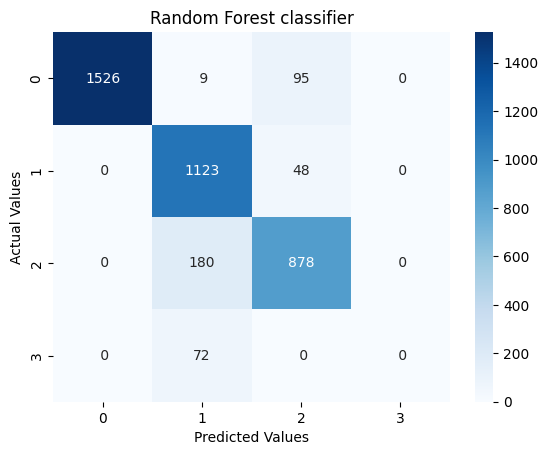

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_mat,annot=True, linecolor='red', fmt='2g', cmap="Blues")
plt.title('Random Forest classifier')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [50]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [59]:
import shap
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


In [60]:
feature_columns = ["maternal_age_group_index", "Residence_index", "Wealth_status_index",
               "Age_of_respondent", "mosquito_net_usage_index", "Smokes_cigarettes_index",
               "fever_last_two_weeks_index","Maternal_education_level_index", "Taking_iron_pills_index",
               "Currently_residing_with_husband_index","Marital_status_index""births_last_five_years"]
    

In [61]:
X_test = test_data.select(feature_columns).toPandas()
y_test = test_data.select("Anemia_level_index").toPandas()

In [62]:
sklearn_rf = RandomForestClassifier()

# Fit the model using the training data
sklearn_rf.fit(X_test, y_test.values.ravel())  # Use .ravel() to convert y_test to a 1D array


RandomForestClassifier()

In [63]:
explainer = shap.TreeExplainer(sklearn_rf)
shap_values = explainer.shap_values(X_test)

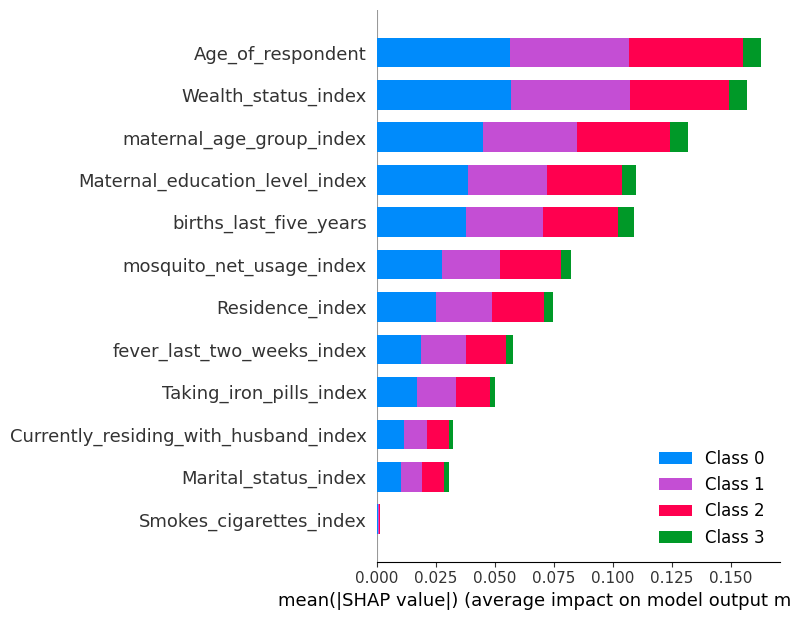

In [64]:
# Plot the SHAP summary plot to see feature importance
shap.summary_plot(shap_values, X_test)

In [78]:
# Make predictions
rf_predictions = rf_model.transform(test_data)

In [79]:
# Calculate accuracy
rf_accuracy = evaluator.evaluate(rf_predictions)

In [80]:
# Calculate precision and recall
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
rf_f1_score = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

In [81]:
# Print metrics
print(f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1 Score: {rf_f1_score}")

Random Forest - Accuracy: 0.8979903332485373, Precision: 0.8881920804436103, Recall: 0.8979903332485373, F1 Score: 0.8909746062026169


In [121]:

# Calculate confusion matrix for Random Forest
rf_tp = rf_predictions.filter((rf_predictions["prediction"] == 1) & (rf_predictions["Anemia_level_index"] == 1)).count()
rf_tn = rf_predictions.filter((rf_predictions["prediction"] == 0) & (rf_predictions["Anemia_level_index"] == 0)).count()
rf_fp = rf_predictions.filter((rf_predictions["prediction"] == 1) & (rf_predictions["Anemia_level_index"] == 0)).count()
rf_fn = rf_predictions.filter((rf_predictions["prediction"] == 0) & (rf_predictions["Anemia_level_index"] == 1)).count()

print(f"RF TP: {rf_tp}, RF TN: {rf_tn}, RF FP: {rf_fp}, RF FN: {rf_fn}")


RF TP: 1149, RF TN: 2562, RF FP: 133, RF FN: 87


# xgboos****

In [136]:
from pyspark.ml import feature
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import xgboost as xgb
from pyspark.ml.linalg import VectorUDT
from xgboost import XGBClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors


In [137]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Convert Spark DataFrame to Pandas DataFrame
train_df = train_data.select("features", "Anemia_level_index").toPandas()
test_df = test_data.select("features", "Anemia_level_index").toPandas()

# Convert the 'features' column (which is a Spark Vector) to a NumPy array
X_train = np.array(train_df["features"].apply(lambda x: x.toArray()).tolist())
y_train = train_df["Anemia_level_index"]

X_test = np.array(test_df["features"].apply(lambda x: x.toArray()).tolist())
y_test = test_df["Anemia_level_index"]

# 2. Train XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=4)  # For multi-class classification
xgb_model.fit(X_train, y_train)

# 3. Predict on test data
y_pred = xgb_model.predict(X_test)

# 4. Evaluation - Calculate Metrics
accuracy = accuracy_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred, average="macro")  # Avoid naming conflict
recall_value = recall_score(y_test, y_pred, average="macro")        # Avoid naming conflict
f1_value = f1_score(y_test, y_pred, average="macro")                # Avoid naming conflict

# 5. Print Results
print(f"Accuracy: {accuracy:.10f}")
print(f"Macro-Averaged Precision: {precision_value:.10f}")
print(f"Macro-Averaged Recall: {recall_value:.10f}")
print(f"Macro-Averaged F1-Score: {f1_value:.10f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9394556093
Macro-Averaged Precision: 0.9294124750
Macro-Averaged Recall: 0.9385068838
Macro-Averaged F1-Score: 0.9336047482
Confusion Matrix:
[[1548    0   82    0]
 [   0 1132   33    6]
 [  10  103  945    0]
 [   0    4    0   68]]


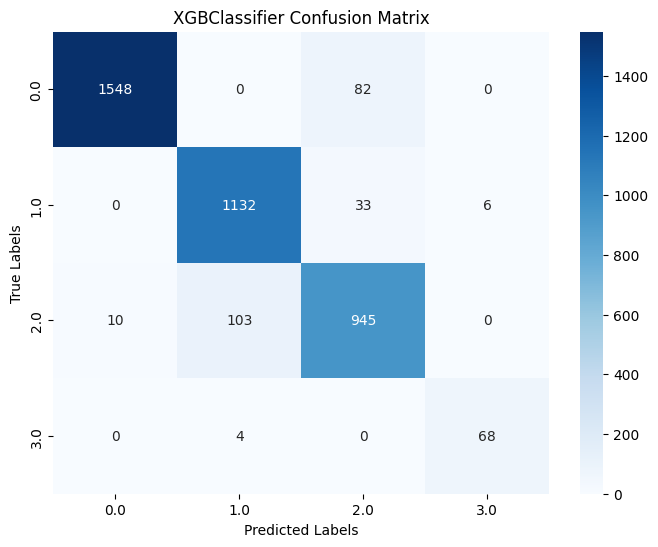

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert confusion matrix to integers
conf_matrix = confusion_matrix(y_test, y_pred).astype(int)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBClassifier Confusion Matrix')
plt.show()

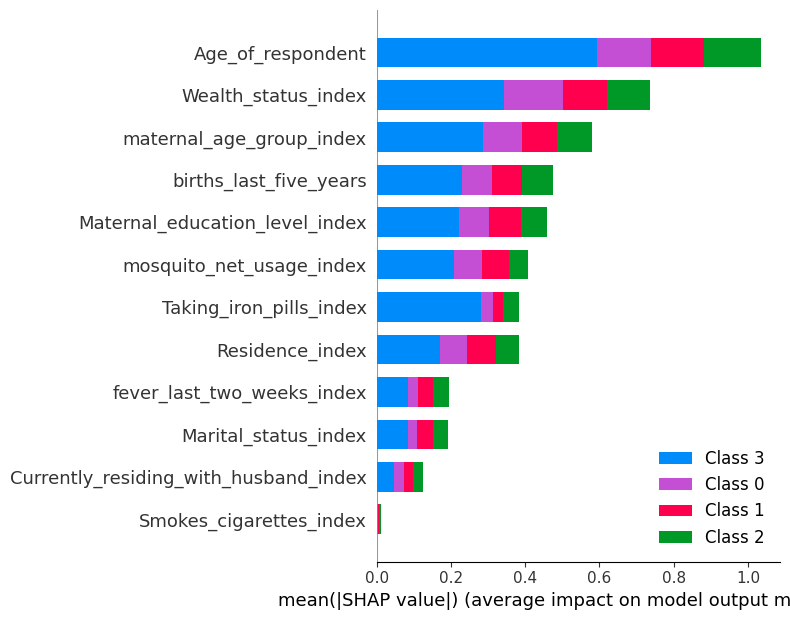

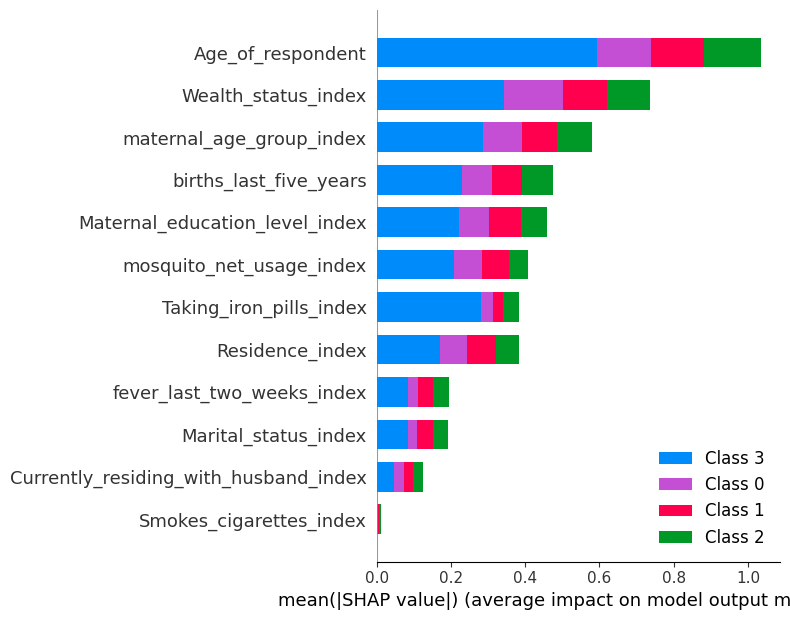

In [139]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb

# Convert Spark DataFrame to Pandas DataFrame
feature_columns = [
    "maternal_age_group_index", "Residence_index", "Wealth_status_index",
    "Age_of_respondent", "mosquito_net_usage_index", "Smokes_cigarettes_index",
    "fever_last_two_weeks_index", "Maternal_education_level_index", "Taking_iron_pills_index",
    "Currently_residing_with_husband_index", "Marital_status_index","births_last_five_years"
]

X_train = train_data.select(feature_columns).toPandas()
y_train = train_data.select("Anemia_level_index").toPandas()

X_test = test_data.select(feature_columns).toPandas()
y_test = test_data.select("Anemia_level_index").toPandas()

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=4)  # Adjust num_class as per your labels
xgb_model.fit(X_train, y_train.values.ravel())  # Use .ravel() to convert y_train to 1D array

# Explain the predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)  # SHAP values for each class

# Plot SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar plot for average feature importance

# Optionally, detailed summary plot for all SHAP values
shap.summary_plot(shap_values, X_test)


In [165]:
df.select("Anemia_level").distinct().show(10)

+------------+
|Anemia_level|
+------------+
|  Not anemic|
|      Severe|
|        Mild|
|    Moderate|
+------------+



In [166]:
df.select("Anemia_level_index").distinct().show(10)

+------------------+
|Anemia_level_index|
+------------------+
|               0.0|
|               1.0|
|               3.0|
|               2.0|
+------------------+



In [167]:
df.groupBy("Anemia_level_index").count().show()

+------------------+-----+
|Anemia_level_index|count|
+------------------+-----+
|               0.0| 5337|
|               1.0| 3974|
|               3.0|  231|
|               2.0| 3594|
+------------------+-----+



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Anemia_level_index", 
    predictionCol="prediction"
)



# Function to evaluate the model
def evaluate_model(predictions, model_name):
    # Calculate evaluation metrics
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    # Print evaluation metrics
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

In [108]:

    # Display confusion matrix
    confusion_matrix = predictions.groupBy("Anemia_level_index", "prediction").count().orderBy("Anemia_level_index", "prediction")
    print(f"\nConfusion Matrix for {model_name}:")
    confusion_matrix.show()

# Train a Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Anemia_level_index")
dt_model = dt.fit(train_data)

# Make predictions on the test data
dt_predictions = dt_model.transform(test_data)

# Evaluate the Decision Tree model
evaluate_model(dt_predictions, "Decision Tree")


Decision Tree - Accuracy: 0.9183, Precision: 0.9199, Recall: 0.9183, F1 Score: 0.9153

Confusion Matrix for Decision Tree:
+------------------+----------+-----+
|Anemia_level_index|prediction|count|
+------------------+----------+-----+
|               0.0|       0.0| 1251|
|               0.0|       2.0|   95|
|               1.0|       1.0| 1034|
|               1.0|       3.0|    8|
|               2.0|       0.0|    1|
|               2.0|       1.0|  124|
|               2.0|       2.0|  790|
|               3.0|       1.0|   47|
|               3.0|       3.0|   14|
+------------------+----------+-----+



In [90]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluator for accuracy, precision, recall, F1-score
evaluator = MulticlassClassificationEvaluator(
    labelCol="Anemia_level_index", 
    predictionCol="prediction", 
    metricName="accuracy"
)

In [91]:
# Decision Tree Classifier setup
dt = DecisionTreeClassifier(
    featuresCol="features", 
    labelCol="Anemia_level_index"
)


In [93]:
# Train the model on the training data
dt_model = dt.fit(train_data)

# Use the trained model to make predictions on the test data
dt_predictions = dt_model.transform(test_data)

In [95]:
# Function to evaluate the model
def evaluate_model(predictions, model_name):
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    # Confusion matrix components
    tp = predictions.filter((predictions["prediction"] == 1) & (predictions["Anemia_level_index"] == 1)).count()
    tn = predictions.filter((predictions["prediction"] == 0) & (predictions["Anemia_level_index"] == 0)).count()
    fp = predictions.filter((predictions["prediction"] == 1) & (predictions["Anemia_level_index"] == 0)).count()
    fn = predictions.filter((predictions["prediction"] == 0) & (predictions["Anemia_level_index"] == 1)).count()
    

In [97]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Anemia_level_index", predictionCol="prediction", metricName="accuracy")

In [98]:
# Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Anemia_level_index")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
evaluate_model(dt_predictions, "Decision Tree")

In [100]:

    # Print evaluation metrics
    print(f"Decision Tree - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
print(f"Decision Tree Confusion Matrix - TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

# Evaluate the decision tree model
evaluate_model(dt_predictions, "Decision Tree")

NameError: name 'precision' is not defined

NameError: name 'predictions' is not defined